[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MeteoSwiss/opendata-nwp-demos/blob/main/08_where_will_the_sun_shine.ipynb)

# ☀️ Where Will the Sun Shine the Day After Tomorrow?

Planning a trip or event in Switzerland? Want to know where sunshine is almost guaranteed?

This notebook presents a map of Switzerland showing the **probability of experiencing more than 6 hours of sunshine** the day after tomorrow, based on the **ICON-CH2-EPS** ensemble forecast.

---

### 🔍 What This Notebook Covers:
- 📥 Fetch ICON-CH2-EPS ensemble forecast for sunshine duration using [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/)'s `ogd_api` module
- 📆 Aggregate values valid during the day after tomorrow
- 🧮 Compute the probability of >6 hours of sunshine
- 🗺️ Visualize the forecast with [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html)

Let’s find out where you can expect plenty of sunshine!


## 📦 Install Dependencies (Colab only)
This cell installs all required dependencies if you're running the notebook in Google Colab.
It is automatically skipped when running in a local Jupyter environment.

In [1]:
import sys

def is_colab():
    return "google.colab" in sys.modules

if is_colab():
    !git clone https://github.com/MeteoSwiss/opendata-nwp-demos.git
    %cd opendata-nwp-demos
    !pip install poetry && poetry config virtualenvs.in-project true && poetry install --no-ansi
    import os, pathlib
    venv = pathlib.Path(".venv")
    site = venv / "lib" / f"python{sys.version_info.major}.{sys.version_info.minor}" / "site-packages"
    sys.path.insert(0, str(site))
    os.environ["ECCODES_DEFINITION_PATH"] = str((venv / "share/eccodes-cosmo-resources/definitions").resolve())


## ☀️ Retrieve ICON-CH2-EPS Forecast (Sunshine Duration)
> **Note:** The **ICON-CH2-EPS** model allows forecasts up to **120 hours ahead**, enabling us to explore probabilities for the day after tomorrow. In contrast, **ICON-CH1-EPS** only provides lead times up to **33 hours**, which is too short for such analysis.  
> 👉 [More on model specifications](https://opendatadocs.meteoswiss.ch/e-forecast-data/e2-e3-numerical-weather-forecasting-model#models-specifications)


In [2]:
from meteodatalab import ogd_api
from datetime import datetime, timedelta, timezone

today_midnight_utc = datetime.now(timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)
# Define lead time range to cover only the day after tomorrow
lead_times_day2 = [timedelta(hours=48), timedelta(hours=72)]

# Create request
req = ogd_api.Request(
    collection="ogd-forecasting-icon-ch2",
    variable="DURSUN",
    ref_time=today_midnight_utc,
    lead_time=lead_times_day2,
    perturbed=True
)

da = ogd_api.get_from_ogd(req)

## 🌍 Regrid to a Regular Grid
Model output is remapped to a regular lat/lon grid using `iconremap()` from `meteodatalab.regrid` for visualization.

In [3]:
from rasterio.crs import CRS
from meteodatalab.operators import regrid

xmin, xmax, ymin, ymax = -0.817, 18.183, 41.183, 51.183
nx, ny = 732, 557

destination = regrid.RegularGrid(CRS.from_epsg(4326), nx, ny, xmin, xmax, ymin, ymax)
da_geo = regrid.iconremap(da, destination)

## 📆 Compute Sunshine Duration for the Day After Tomorrow
The `DURSUN` parameter represents the accumulated sunshine duration (in seconds) from the reference time up to the given forecast lead time. To calculate the sunshine duration specifically for the day after tomorrow, you need to subtract the value at lead time +48h (start of the day after tomorrow) from the value at lead time +72h (end of that day). This gives the total sunshine duration for the 24-hour period of interest

In [4]:
# Subtract cumulative value of +48h from +72h
da_diff = da_geo.diff(dim="lead_time")

## 📊 Compute Probability of Sunshine > 6 Hours


In [5]:
threshold_seconds = 6 * 3600  # 6 hours in seconds
mask = da_diff > threshold_seconds
prob_sunshine = mask.mean(dim="eps") * 100
prob_sunshine.attrs = da_diff.attrs
prob_sunshine.attrs["long_name"] = "Probability of sunshine > 6 hours"
prob_sunshine.attrs["units"] = "%"

## 🗺️ Plot the Sunshine Probability Map


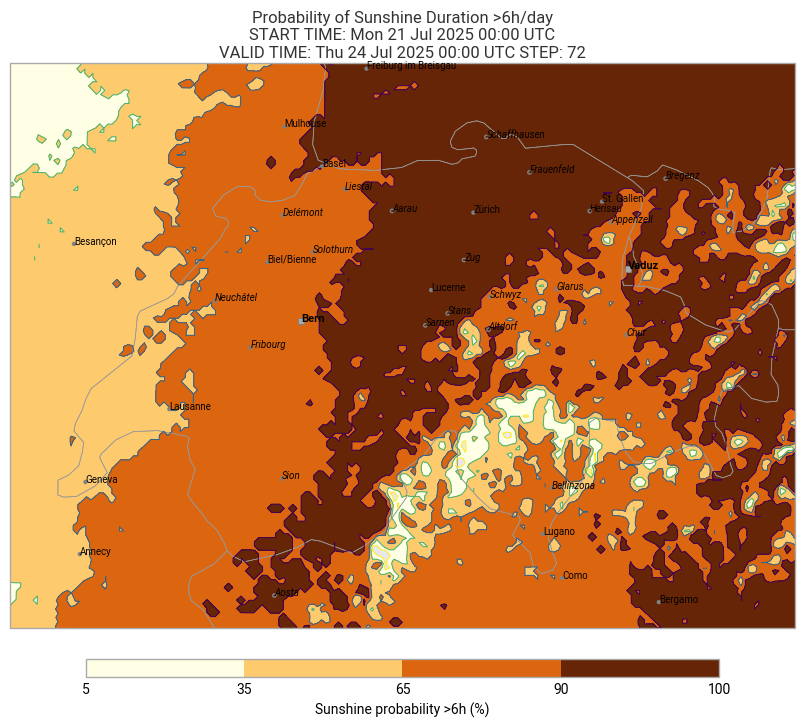

In [6]:
import cartopy.crs as ccrs
from earthkit.plots.geo import bounds, domains
from earthkit.plots.styles import Style, Contour
import earthkit
import numpy as np
import pandas as pd

bbox = bounds.BoundingBox(5.7, 10.5, 45.6, 48, ccrs.Geodetic())
domain = domains.Domain.from_bbox(bbox=bbox)

levels = [5, 35, 65, 90, 100.01]

contourf_style = Style(
    levels=levels,
    colors="YlOrBr",
    legend_style="colorbar",
)

contour_style = Contour(
    levels=levels,
    legend_style=None,
)

chart = earthkit.plots.Map(domain=domain)
chart.contourf(prob_sunshine, x="lon", y="lat", style=contourf_style)
chart.contour(prob_sunshine, x="lon", y="lat", style=contour_style)
chart.borders()
chart.cities("high")
chart.land()
chart.legend(label="Sunshine probability >6h (%)")

# Extract reference and lead time
ref_time = pd.to_datetime(prob_sunshine.coords["ref_time"].values[0])
lead_time = prob_sunshine.coords["lead_time"].values[0]
lead_hours = int(lead_time.astype("timedelta64[h]") / np.timedelta64(1, "h"))
valid_time = ref_time + pd.to_timedelta(lead_hours, unit="h")
title = "\n".join([
    "Probability of Sunshine Duration >6h/day",
    f"START TIME: {ref_time.strftime('%a %d %b %Y %H:%M')} UTC",
    f"VALID TIME: {valid_time.strftime('%a %d %b %Y %H:%M')} UTC STEP: {lead_hours}"
])
chart.title(text=title)
chart.show()